In [1]:
import numpy as np
from modules.BS_MixG_model import C_MixG
from modules.BS_Theoretical_Model import BS_Theoretical_Value, add_noise_to_option_values
from matplotlib import pyplot as plt

In [2]:
# 设置随机数种子
np.random.seed(0)

In [3]:
n = 25
# 从1000-1700均匀取25个数
X = np.linspace(1000, 1700, n)
T = 30
r = 0.045
d = 0.025
ST = 1365
tau = T / 365
sigma_0 = 0.2
sigma_1000 = 0.2  # 当 X = 1000 时的波动率
sigma_1700 = 0.4  # 当 X = 1700 时的波动率

sigma_0

0.2

设置非参数模型优化问题

In [4]:
def loss(C_pred, C_true):
    if C_pred.shape != C_true.shape:
        raise ValueError("C_pred and C_true should have the same shape")
    return np.mean((C_pred - C_true) ** 2)

In [5]:
BS_Value = BS_Theoretical_Value(X, ST, T, r, d, sigma_1000, sigma_1700)
# C_obs = add_noise_to_option_values(BS_Value, X)
C_obs = BS_Value
# 优化参数
mu_init = np.random.uniform(low=7.107, high=7.265, size=(n + 1))
pi_init = np.ones(n + 1) / (n + 1)
mu = mu_init
pi = pi_init
C_pred = C_MixG(X, r, tau, sigma_0, mu, pi)
# 损失函数
print("Loss: ", loss(C_pred, C_obs))

Loss:  1874.0586782398273


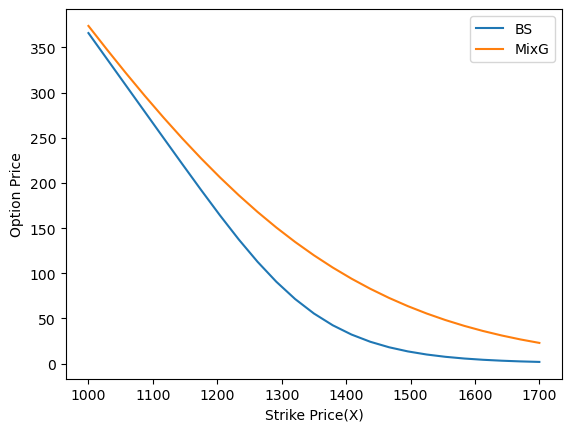

In [6]:
# 绘制图像BS和混合模型的对比
plt.plot(X, C_obs, label='BS')
plt.plot(X, C_pred, label='MixG')
plt.xlabel('Strike Price(X)')
plt.ylabel('Option Price')
plt.legend()
plt.show()

In [7]:
# 计算Expection价值
def Expection(mu, pi):
    return np.dot(np.exp(mu), pi) * np.exp(sigma_0 ** 2 / 2)

# 计算看涨期权下未来价值
def FutureValue(r, d, tau, X):
    return (np.exp((r - d) * tau) * X).mean()

FV = FutureValue(r, d, tau, X)
print("Expection: ", Expection(mu, pi))
print("Future Value: ", FV)

Expection:  1368.6626528517297
Future Value:  1352.2210030640301


进行对权重$\pi(·)$的二次优化

In [8]:
from scipy.optimize import minimize, LinearConstraint

# 目标函数
def objective(pi, X, r, tau, sigma_0, mu, C_obs):
    # C_pred 通过 C_MixG 计算
    C_pred = C_MixG(X, r, tau, sigma_0, mu, pi)
    return loss(C_pred, C_obs)


def constraint_expection(pi, mu):
    # 计算期望值和未来价值
    E_value = Expection(mu, pi)
    return E_value - FV

# 约束条件
cons = {'type': 'eq', 'fun': constraint_expection, 'args': (mu,)}
epsilon = 1e-6
bounds = [(epsilon, 1 - epsilon)] * (n + 1)

# pi之和为1

pi_init = np.ones(n + 1) / (n + 1)  # 初始猜测的 pi

linear_constraint_1 = LinearConstraint(np.ones(n + 1), 1, 1)
res = minimize(objective, x0=pi_init, args=(X, r, tau, sigma_0, mu, C_obs), method='SLSQP', 
               constraints=[cons, linear_constraint_1], bounds=bounds,
               options={'disp': True, 'ftol': 1e-9})

pi_optimized = res.x
pi_optimized

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1167.2409826387266
            Iterations: 7
            Function evaluations: 81
            Gradient evaluations: 3


array([1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00000408e-06, 1.00000000e-06, 1.00000336e-06, 1.00000073e-06,
       1.00000831e-06, 1.00000553e-06, 1.00000000e-06, 8.99795476e-01,
       1.00000000e-06, 1.00000398e-06, 1.00000053e-06, 1.00000191e-06,
       1.00000000e-06, 1.00000000e-06, 1.00000000e-06, 1.00000000e-06,
       1.00001074e-06, 1.00000000e-06, 1.00180524e-01, 1.00000000e-06,
       1.00000422e-06, 1.00000000e-06])

Loss:  1874.0586782398273
Loss:  1167.2409826387266
Expection:  1352.2210031338482
Future Value:  1352.2210030640301


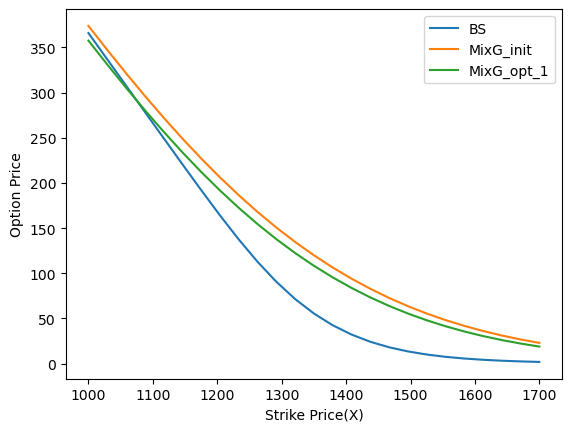

In [9]:
C_pred_opt_1 = C_MixG(X, r, tau, sigma_0, mu, pi_optimized)
print("Loss: ", loss(C_pred, C_obs))
print("Loss: ", loss(C_pred_opt_1, C_obs))

print("Expection: ", Expection(mu, pi_optimized))
print("Future Value: ", FV)

# Expection:  1346.0498046161208
# Future Value:  1352.2210030640301

# 绘制图像BS和混合模型的对比
plt.plot(X, C_obs, label='BS')
plt.plot(X, C_pred, label='MixG_init')
plt.plot(X, C_pred_opt_1, label='MixG_opt_1')
plt.xlabel('Strike Price(X)')
plt.ylabel('Option Price')
plt.legend()
plt.show()

使用Newton Ralphson Iterations优化损失函数

In [10]:
from modules.BS_MixG_model import C_MixG_Torch
import torch
from utils import loss_torch

In [11]:
def gradient_hessian(X, r, tau, sigma_0, mu_torch, pi, C_obs):
    # Calculate the value of call options in G Mixtures model
    if not isinstance(mu_torch, torch.Tensor) or not isinstance(C_obs, torch.Tensor) or not isinstance(X, torch.Tensor):
        raise ValueError("mu_torch, C_obs, and X should be torch.Tensor")
    if mu_torch.requires_grad is False:
        raise ValueError("mu_torch should require grad")
    C_pred = C_MixG_Torch(X, r, tau, sigma_0, mu_torch, pi)
    loss = loss_torch(C_pred, C_obs)

    # 计算 loss 相对于 mu_torch 的梯度
    grad = torch.autograd.grad(loss, mu_torch, create_graph=True)[0]
    hessian_matrix = torch.zeros(n + 1, n + 1)
    # 计算 Hessian，每个元素是梯度对 mu_torch 的二次导数
    for i in range(n + 1):
        grad_i = grad[i]
        hessian_row = torch.autograd.grad(grad_i, mu_torch, retain_graph=True)[0]
        hessian_matrix[i] = hessian_row

    return grad, hessian_matrix



$$
\frac{d}{d\mu} \left( e^{-r\tau + \frac{\sigma^2}{2} + \mu} \bar{\Phi} \left( \frac{\ln X - (\mu + \sigma^2)}{\sigma} \right) \right) = e^{-r\tau + \frac{\sigma^2}{2} + \mu} \cdot \left[\frac{1}{\sigma} \phi \left( \frac{\ln X - (\mu + \sigma^2)}{\sigma} \right) + \bar{\Phi} \left( \frac{\ln X - (\mu + \sigma^2)}{\sigma} \right)\right]
$$

$$
e^{-r\tau} X \cdot \frac{1}{\sigma} \phi \left( \frac{\ln X - \mu}{\sigma} \right)
$$



In [12]:
# mu_new = mu - Hessian^(-1) * grad
# Convert to torch tensor
X_torch = torch.tensor(X, dtype=torch.float32)
C_obs_torch = torch.tensor(C_obs, dtype=torch.float32)
mu_opt = torch.tensor(mu, dtype=torch.float32, requires_grad=True)
pi_opt = torch.tensor(pi_optimized, dtype=torch.float32)

cnt = 0

print("Loss before Opt : ", loss(C_pred_opt_1, C_obs))
while True:
    cnt += 1
    grad, hessian = gradient_hessian(X_torch, r, tau, sigma_0, mu_opt, pi_opt, C_obs_torch)
    mu_opt = mu_opt - torch.inverse(hessian) @ grad
    with torch.no_grad():
        C_pred_tmp = C_MixG_Torch(X_torch, r, tau, sigma_0, mu_opt, pi_opt)
        loss = loss_torch(C_pred_tmp, C_obs_torch)
    # print("Loss: ", loss)
    if torch.norm(grad) < 1e-6 or cnt > 10:
        break

print("Loss after Opt : ", loss.item())

Loss before Opt :  1167.2409826387266


/Users/shay/Workplace/BS Model/modules/BS_MixG_model.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/Users/shay/Workplace/BS Model/modules/BS_MixG_model.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi = torch.tensor(pi, dtype=torch.float32)


Loss after Opt :  721.8633422851562


Expection:  1317.2406442465751
Future Value:  1352.2210030640301


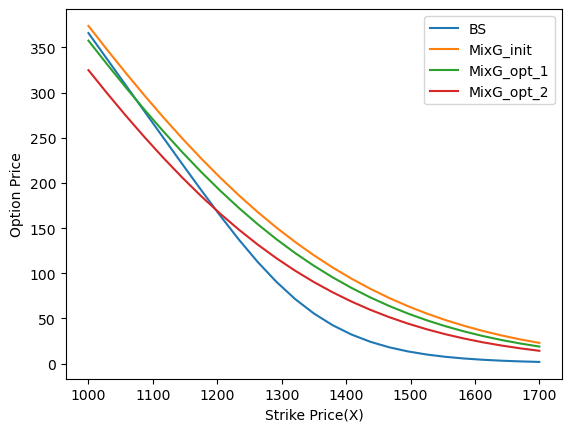

In [13]:
# Convert to numpy array
mu_opt = mu_opt.detach().numpy()
pi_opt = pi_optimized

# Calculate the Expection and Future Value
print("Expection: ", Expection(mu_opt, pi_opt))
print("Future Value: ", FV)
C_pred_opt_2 = C_MixG(X, r, tau, sigma_0, mu_opt, pi_opt)
# 绘制图像BS和混合模型的对比
plt.plot(X, C_obs, label='BS')
plt.plot(X, C_pred, label='MixG_init')
plt.plot(X, C_pred_opt_1, label='MixG_opt_1')
plt.plot(X, C_pred_opt_2, label='MixG_opt_2')
plt.xlabel('Strike Price(X)')
plt.ylabel('Option Price')
plt.legend()
plt.show()